# Variational Bayesian Last Layer (VBLL) with SNGP Regression

In [1]:
%pip install lightning-uq-box

Note: you may need to restart the kernel to use updated packages.


In [65]:
import torch
import torch.nn as nn
import os
from functools import partial
from torch.optim import Adam
from lightning_uq_box.uq_methods import SNGPRegression, VBLLRegression
from lightning_uq_box.datamodules import ToyDUE
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.models.fc_resnet import FCResNet
from lightning_uq_box.viz_utils import (
    plot_toy_regression_data,
    plot_predictions_regression,
    plot_training_metrics,
)

from lightning_uq_box.uq_methods.spectral_normalized_layers import spectral_normalize_model_layers, collect_input_sizes
from lightning_uq_box.uq_methods.sngp import RandomFourierFeatures

import tempfile

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# temporary directory for saving
my_temp_dir = tempfile.mkdtemp()

seed_everything(42)

Seed set to 42


42

## Datamodule

In [67]:
datamodule = ToyDUE(batch_size=32, n_samples=128)
datamodule.__dict__.keys()
X_train, y_train, X_test, y_test, train_loader, test_loader = (
    datamodule.X_train,
    datamodule.y_train,
    datamodule.X_test,
    datamodule.y_test,
    datamodule.train_dataloader(),
    datamodule.val_dataloader(),
)

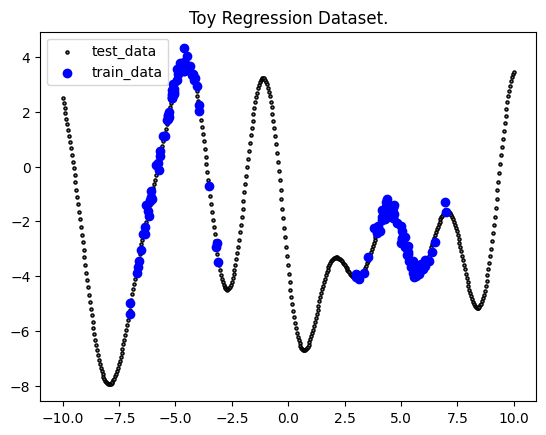

In [68]:
fig = plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

In [69]:
# todo should be spectral normalized
feature_extractor = FCResNet(input_dim=1, features=64, depth=4, num_outputs=64, dropout_rate=0.0, activation="elu")
input_dims = collect_input_sizes(feature_extractor, 1)
feature_extractor = spectral_normalize_model_layers(feature_extractor, input_dimensions=input_dims, n_power_iterations=1)

# todo be able to get 
rff_features = RandomFourierFeatures(in_dim=64, num_random_features=128)

model = nn.Sequential(feature_extractor, rff_features)

In [73]:
vbll_model = VBLLRegression(
    model=model,
    regularization_weight=(1 / X_train.shape[0]),
    optimizer=partial(torch.optim.Adam, lr=3e-3),
    prior_scale=1.0,
    wishart_scale=0.1
)
vbll_model

VBLLRegression(
  (model): Sequential(
    (0): Sequential(
      (0): FCResNet(
        (first): Linear(in_features=1, out_features=64, bias=True)
        (residuals): ModuleList(
          (0-3): 4 x Linear(in_features=64, out_features=64, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (last): Linear(in_features=64, out_features=64, bias=True)
      )
      (1): RandomFourierFeatures()
    )
    (1): Regression()
  )
  (train_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (R2): R2Score()
    (RMSE): MeanSquaredError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (R2): R2Score()
    (RMSE): MeanSquaredError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (R2): R2Score()
    (RMSE): MeanSquaredError(),
    prefix=test
  )
)

## Trainer

In [71]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=400,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=my_temp_dir,
    gradient_clip_val=1.0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [72]:
trainer.fit(vbll_model, datamodule)

Missing logger folder: /tmp/tmpu5i003qk/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 25.2 K
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
25.2 K    Trainable params
1         Non-trainable params
25.2 K    Total params
0.101     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


AssertionError: 

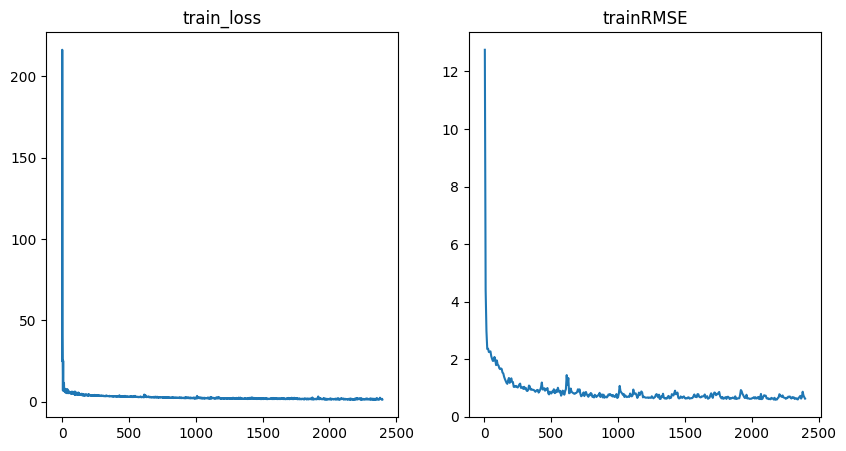

In [61]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

## Prediction

In [62]:
preds = vbll_model.predict_step(X_test)

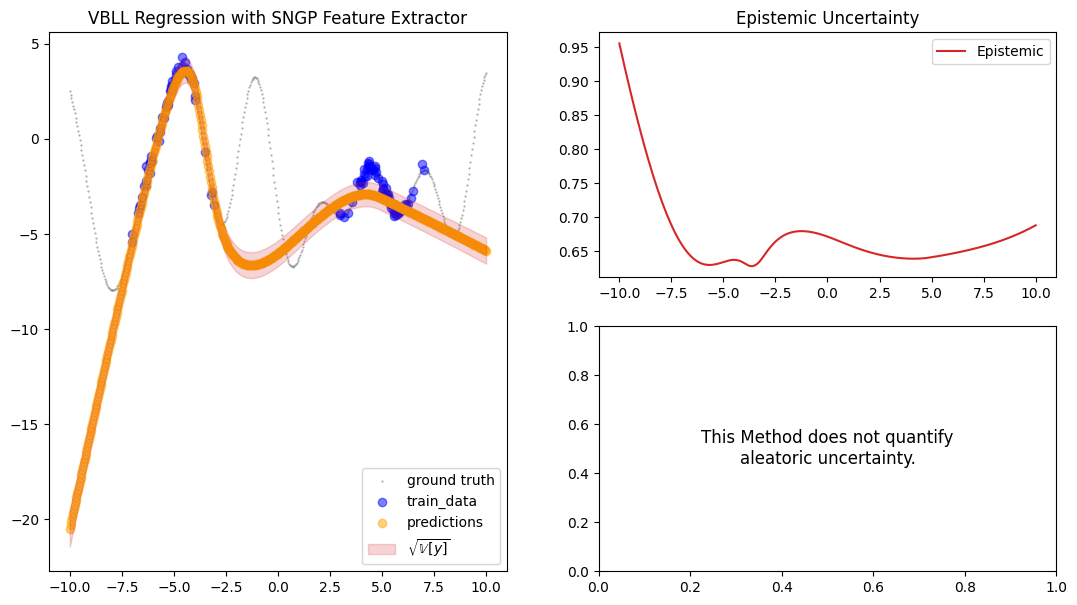

In [63]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"].squeeze(-1),
    epistemic=preds["pred_uct"].squeeze(-1),
    title="VBLL Regression with SNGP Feature Extractor",
    show_bands=False,
)